In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from statistics import mean
import numpy as np
import time


ori_df = pd.read_csv('Hotel Reservations.csv')
ori_df = ori_df.drop(['Booking_ID', 'arrival_year'], axis=1)
print(ori_df.info())
ori_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_month                         36275 non-null  int64  
 9   arrival_date                          36275 non-null  int64  
 10  market_segment_type                   36275 non-null  object 
 11  repeated_guest 

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,10,17,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,4,21,Online,0,0,0,94.50,0,Canceled


In [3]:
numeric_columns = ori_df.select_dtypes(include ='number')
non_numeric_columns = ori_df.select_dtypes(exclude ='number')

for u in numeric_columns.columns:
  if u != 'booking_status':
    numeric_columns[u] -= numeric_columns[u].mean()            # mean == 0.0
    numeric_columns[u] /= abs(numeric_columns[u]).max()             # -1 ≤ x ≤ 1

df = pd.concat([numeric_columns, non_numeric_columns], axis=1)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,0.071942,-0.01064,0.030581,-0.013808,-0.031976,0.387871,0.401072,-0.882750,-0.026312,-0.001799,-0.002652,-0.088011,-0.141463,Meal Plan 1,Room_Type 1,Offline,Not_Canceled
1,0.071942,-0.01064,0.192151,0.053779,-0.031976,-0.224259,0.556747,-0.623060,-0.026312,-0.001799,-0.002652,0.007459,0.086830,Not Selected,Room_Type 1,Online,Not_Canceled
2,-0.392087,-0.01064,0.192151,-0.081395,-0.031976,-0.235439,-0.844325,0.805233,-0.026312,-0.001799,-0.002652,-0.099464,-0.141463,Meal Plan 1,Room_Type 1,Online,Canceled
3,0.071942,-0.01064,-0.130988,-0.013808,-0.031976,0.351534,-0.377301,0.285854,-0.026312,-0.001799,-0.002652,-0.007842,-0.141463,Meal Plan 1,Room_Type 1,Online,Canceled
4,0.071942,-0.01064,0.030581,-0.081395,-0.031976,-0.104069,-0.532976,-0.298448,-0.026312,-0.001799,-0.002652,-0.020440,-0.141463,Not Selected,Room_Type 1,Online,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,0.535971,-0.01064,0.192151,0.256541,-0.031976,-0.000650,0.089723,-0.817827,-0.026312,-0.001799,-0.002652,0.147457,0.086830,Meal Plan 1,Room_Type 4,Online,Not_Canceled
36271,0.071942,-0.01064,0.030581,0.053779,-0.031976,0.399051,0.401072,0.091086,-0.026312,-0.001799,-0.002652,-0.028571,0.315122,Meal Plan 1,Room_Type 1,Online,Canceled
36272,0.071942,-0.01064,0.192151,0.256541,-0.031976,0.175442,-0.065952,-0.947672,-0.026312,-0.001799,-0.002652,-0.011530,0.315122,Meal Plan 1,Room_Type 1,Online,Not_Canceled
36273,0.071942,-0.01064,-0.130988,0.053779,-0.031976,-0.062142,-0.532976,0.350776,-0.026312,-0.001799,-0.002652,-0.020440,-0.141463,Not Selected,Room_Type 1,Online,Canceled


In [4]:
# One hot encode categorical columns
columns = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

for x in columns:
    enc = pd.get_dummies(df[x])
    df = df.drop(x, axis=1)
    df = df.join(enc)

y = df['booking_status']
x = df.drop(columns='booking_status')
x_train,x_test,y_train,y_test =  train_test_split(x,y)


Time taken to run cross validations: 89.979 seconds


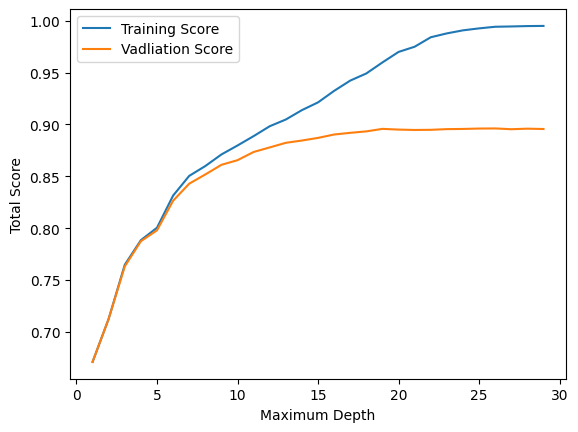

In [5]:

# Using cross validation to find the optimum max depth hyperparameter
max_depth_list = range(1,30)
scores = []

start_time = time.time()
for depth in max_depth_list:
  clf = RandomForestClassifier(max_depth=depth)
  scores.append(cross_validate(clf, x_train, y_train, cv=3, return_train_score=True))
end_time = time.time() - start_time

print(f"Time taken to run cross validations: {end_time:.3f} seconds")

average_training_score = []
average_validation_score = []

for depth in max_depth_list: 
  average_training_score.append(mean(scores[depth - 1]['train_score']))
  average_validation_score.append(mean(scores[depth - 1]['test_score']))

clf_depth_range = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(clf_depth_range, average_training_score, label='Training Score') # Plot training error over domain
plt.plot(clf_depth_range, average_validation_score, label='Vadliation Score') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Total Score') # Label y-axis
plt.legend() # Show plot labels as legend
plt.show()

Time taken to run cross validations: 87.423 seconds


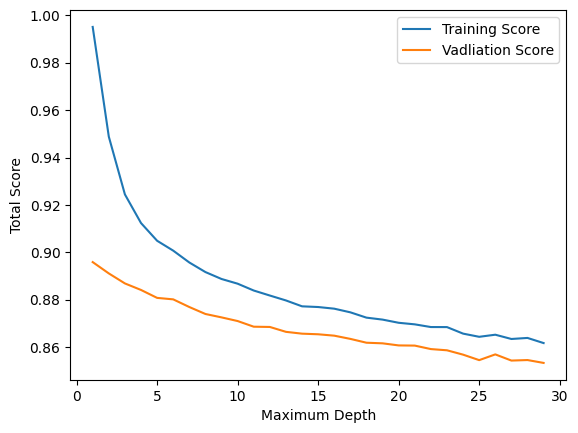

In [6]:

# Using cross validation to find the optimum min samples leaf hyperparameter
nrange = range(1,30)
scores = []

start_time = time.time()
for n in nrange:
  clf = RandomForestClassifier(min_samples_leaf=n)
  scores.append(cross_validate(clf, x_train, y_train, cv=3, return_train_score=True))
end_time = time.time() - start_time

print(f"Time taken to run cross validations: {end_time:.3f} seconds")

average_training_score = []
average_validation_score = []

for depth in max_depth_list: 
  average_training_score.append(mean(scores[depth - 1]['train_score']))
  average_validation_score.append(mean(scores[depth - 1]['test_score']))

clf_min_samples_leaf = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(clf_min_samples_leaf, average_training_score, label='Training Score') # Plot training error over domain
plt.plot(clf_min_samples_leaf, average_validation_score, label='Vadliation Score') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Total Score') # Label y-axis
plt.legend() # Show plot labels as legend
plt.show()

In [7]:
# Using randomized search CV to find the optimum hyperparemeters
tree = RandomForestClassifier()
param_dist = {
    'max_depth': np.arange(1, 30),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10)
}

start_time = time.time()
random_search = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5,scoring="accuracy")
random_search.fit(x_train, y_train)
end_time = time.time() - start_time

best_params = random_search.best_params_

print(f"Best parameters: { best_params }")
print(f"Time to compute the best parameters: {end_time:.3f} seconds")

Best parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 26}
Time to compute the best parameters: 44.526 seconds


Random forest accuracy score: 89.29319660381519%
Time to train random forest: 1.372 seconds
              precision    recall  f1-score   support

    Canceled       0.88      0.77      0.82      2932
Not_Canceled       0.90      0.95      0.92      6137

    accuracy                           0.89      9069
   macro avg       0.89      0.86      0.87      9069
weighted avg       0.89      0.89      0.89      9069



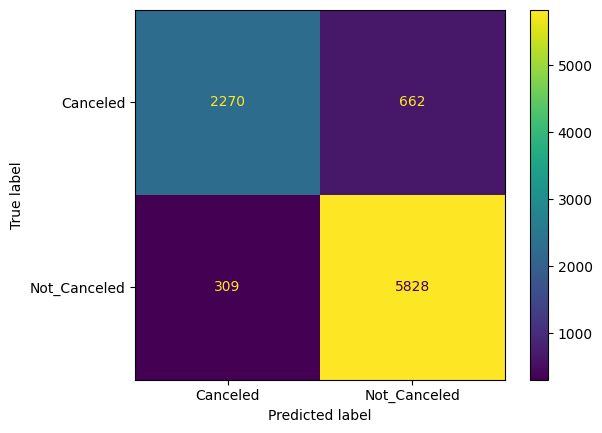

In [8]:
# Generate classification report and confusion matrix
start_time = time.time()
clf = RandomForestClassifier(max_depth=21, min_samples_leaf=1, min_samples_split=6)
history = clf.fit(x_train,y_train)
end_time = time.time() - start_time

y_pred_test = clf.predict(x_test)
print(f'Random forest accuracy score: {accuracy_score(y_test, y_pred_test) * 100}%')
print(f"Time to train random forest: {end_time:.3f} seconds")

report = classification_report(y_test, y_pred_test)
print(report)

cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()


Time to compute the importances: 0.008 seconds


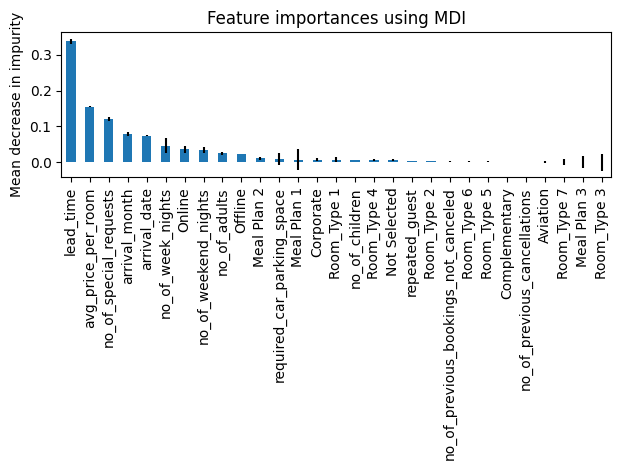

In [9]:
# computing feature importance
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
end_time = time.time() - start_time
print(f"Time to compute the importances: {end_time:.3f} seconds")

sorted_idx = clf.feature_importances_.argsort()[::-1]
forest_importances = pd.Series(importances[sorted_idx], index=x.columns[sorted_idx])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Time to compute the importances: 19.934 seconds


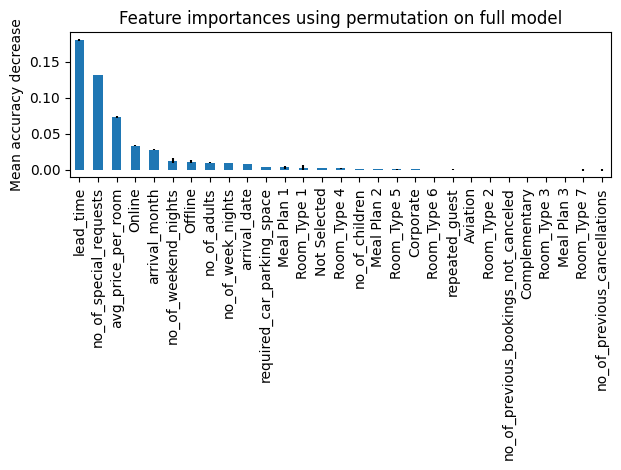

In [10]:
start_time = time.time()
result = permutation_importance(
    clf, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
end_time = time.time() - start_time
print(f"Time to compute the importances: {end_time:.3f} seconds")

# sort the feature importances from high to low
sorted_idx = result.importances_mean.argsort()[::-1]
forest_importances = pd.Series(result.importances_mean[sorted_idx], index=x.columns[sorted_idx])
fig, ax = plt.subplots()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
fig.tight_layout()
plt.show()

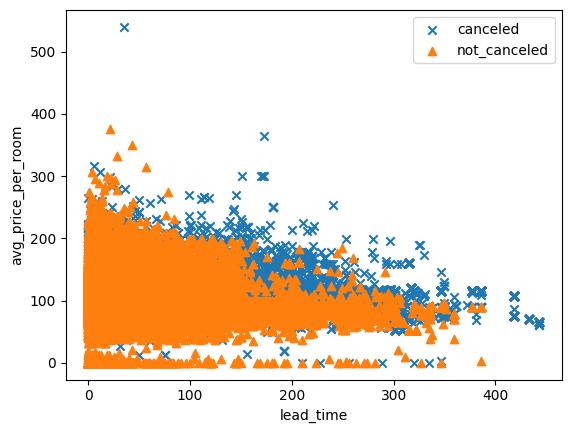

In [11]:
# Attempt to visualize the correlation between leadtime and average price per room based on the booking status
# Create two subsets of the dataframe based on 'booking_status'
canceled_df = ori_df[ori_df['booking_status'] == 'Canceled']
not_canceled_df = ori_df[ori_df['booking_status'] == 'Not_Canceled']

# Plot the subsets using different markers
plt.scatter(canceled_df['lead_time'], canceled_df['avg_price_per_room'], marker='x', label='canceled')
plt.scatter(not_canceled_df['lead_time'], not_canceled_df['avg_price_per_room'], marker='^', label='not_canceled')

# Add labels and legend
plt.xlabel('lead_time')
plt.ylabel('avg_price_per_room')
plt.legend()

# Show the plot
plt.show()
